# Removing clouds in Landsat images

## Searching for Landsat scenes

In [3]:
%pip install landsatexplore

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement landsatexplore (from versions: none)
ERROR: No matching distribution found for landsatexplore

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from landsatxplore.api import API
import os

# Your USGS  credentials
username = os.environ.get('arelyayalaa5')
password = os.environ.get('DatosTesis500.')

# Initialize a new API instance
api = API('arelyayalaa5', 'DatosTesis500.')

# Search for Landsat TM scenes
scenes = api.search(
    dataset='landsat_ot_c2_l2',
    latitude=-33.781963,
    longitude=18.522578,
    start_date='2020-01-01',
    end_date='2023-12-31'
)

# log out
api.logout()

In [ ]:
!pip install pyperclip

In [ ]:
import pandas as pd

# Create DataFrame from the scenes
df_scenes = pd.DataFrame(scenes)
df_scenes = df_scenes[['display_id','wrs_path', 'wrs_row','satellite','cloud_cover','acquisition_date']]
df_scenes = df_scenes[df_scenes.wrs_row == 83]
df_scenes.sort_values('acquisition_date', ascending=False, inplace=True)

# Print the first 5 scenes
print(len(df_scenes)) #value: 55
#df_scenes.to_clipboard()
df_scenes.head()


50


,display_id,wrs_path,wrs_row,satellite,cloud_cover,acquisition_date
0,LC08_L2SP_175083_20231230_20240108_02_T1,175,83,8,68,2023-12-30
2,LC09_L2SP_175083_20231222_20231223_02_T1,175,83,9,10,2023-12-22
4,LC08_L2SP_175083_20231214_20240102_02_T1,175,83,8,34,2023-12-14
6,LC09_L2SP_175083_20231206_20231207_02_T1,175,83,9,0,2023-12-06
8,LC08_L2SP_175083_20231128_20231208_02_T1,175,83,8,51,2023-11-28


In [ ]:
from landsatxplore.earthexplorer import EarthExplorer
import os

def get_scene(ID):

    # Initialize the API
    username = os.environ.get('arelyayalaa5')
    password = os.environ.get('DatosTesis500.')
    ee = EarthExplorer('arelyayalaa5', 'DatosTesis500.')

    # Download the scene
    try:
        ee.download(ID, output_dir='./data')
        print('{} succesful'.format(ID))

    # Additional error handling
    except:
        if os.path.isfile('./data/{}.tar'.format(ID)):
            print('{} error but file exists'.format(ID))
        else:
            print('{} error'.format(ID))

    ee.logout()

get_scene('LC08_L2SP_175083_20230418_20230429_02_T1')
get_scene('LC09_L2SP_175083_20230410_20230412_02_T1')

Download failed with dataset id 1 of 3. Re-trying with the next one.


100%|██████████| 883M/883M [02:33<00:00, 6.04MB/s]


None of the archived ids succeeded! Update necessary!
LC08_L2SP_175083_20230418_20230429_02_T1 error but file exists


EarthExplorerError: EE: login failed.

In [ ]:
import tarfile

IDs = ['LC09_L2SP_175083_20230410_20230412_02_T1',
       'LC08_L2SP_175083_20230418_20230429_02_T1']

for ID in IDs:
    # Extract files from tar archive
    tar = tarfile.open('./data/{}.tar'.format(ID))
    tar.extractall('./data/{}'.format(ID))
    tar.close()


## Visualize the Landsat scenes

In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

def get_RGB(ID):

    # Load Blue (B2), Green (B3) and Red (B4) bands
    B2 = tiff.imread('./data/{}/{}_SR_B2.TIF'.format(ID, ID))
    B3 = tiff.imread('./data/{}/{}_SR_B3.TIF'.format(ID, ID))
    B4 = tiff.imread('./data/{}/{}_SR_B4.TIF'.format(ID, ID))

    # Stack and scale bands
    RGB = np.dstack((B4, B3, B2))
    RGB = np.clip(RGB*0.0000275-0.2, 0, 1)

    # Clip to enhance contrast
    RGB = np.clip(RGB,0,0.3)/0.3

    return RGB

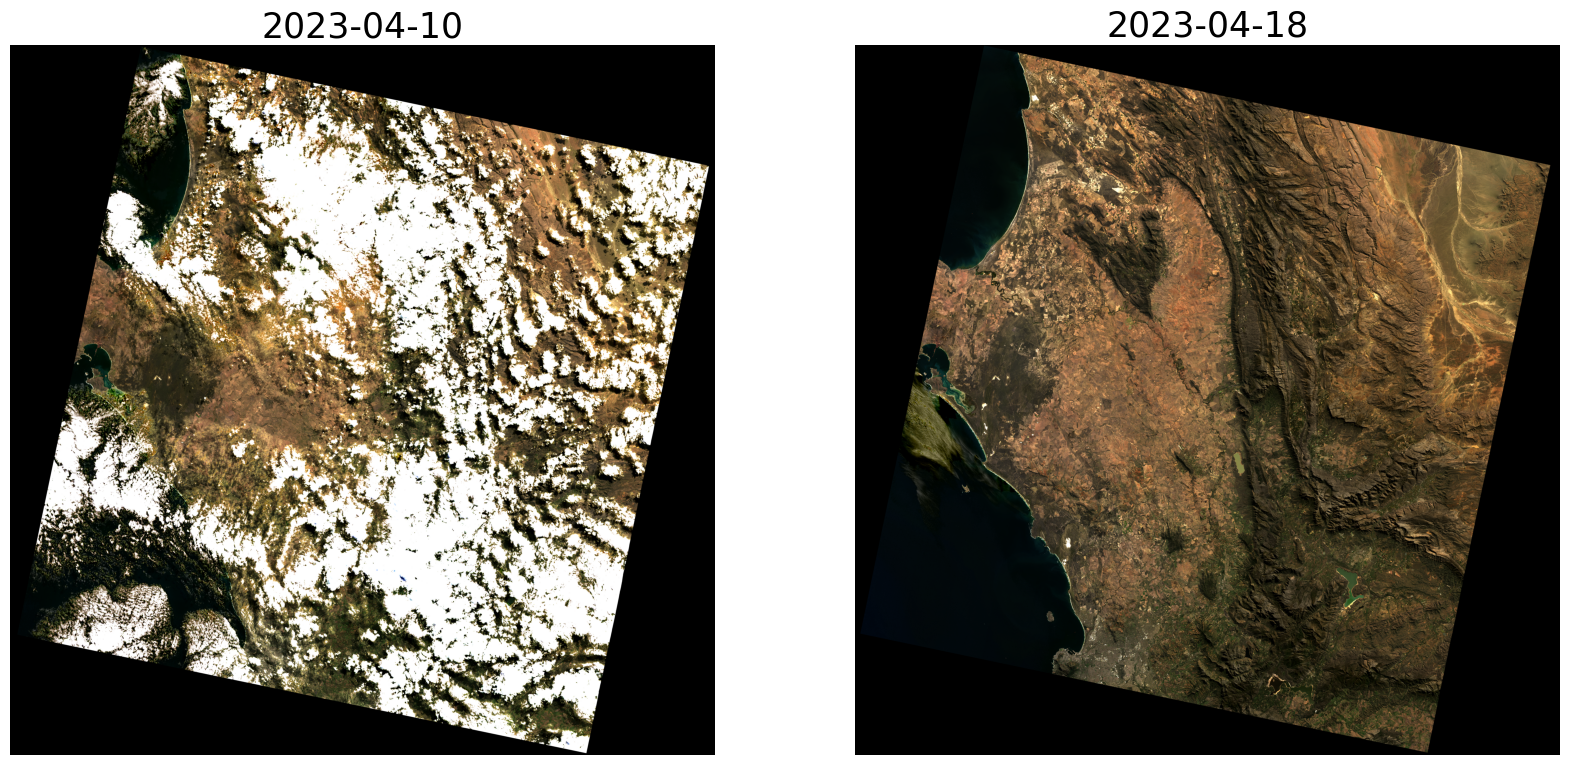

In [ ]:
IDs = ['LC09_L2SP_175083_20230410_20230412_02_T1',
       'LC08_L2SP_175083_20230418_20230429_02_T1']

fig, ax = plt.subplots(1,2,figsize=(20, 10))

# Cloudy image
ID = IDs[0]
RGB = get_RGB(ID)
ax[0].imshow(RGB)
ax[0].set_title('2023-04-10',size=25)
ax[0].set_axis_off()

# Non-cloudy image
ID = IDs[1]
RGB = get_RGB(ID)
ax[1].imshow(RGB)
ax[1].set_title('2023-04-18',size=25)
ax[1].set_axis_off()

# Get cloud masks

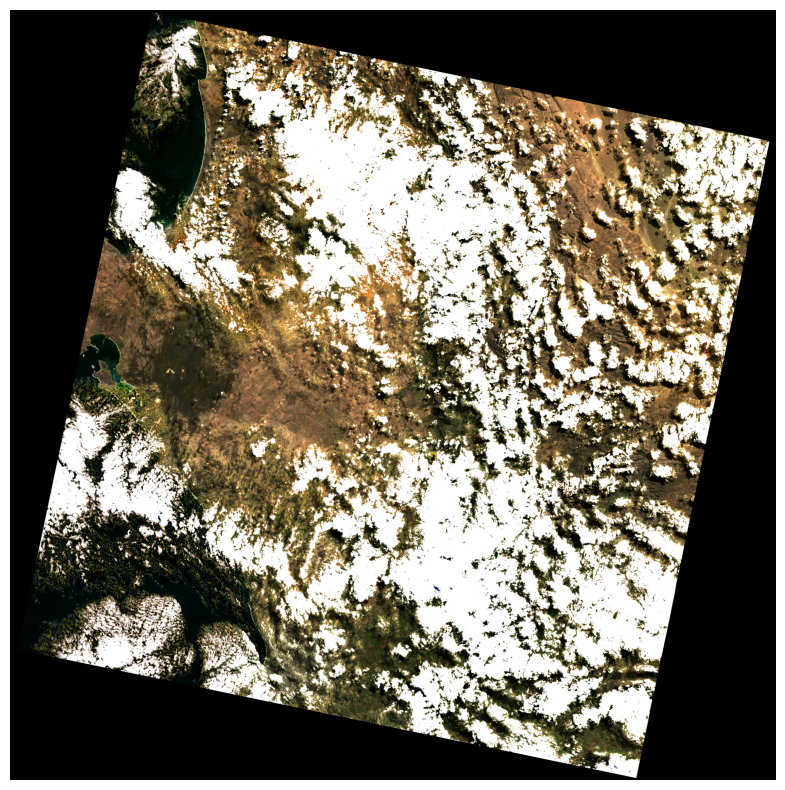

In [ ]:
ID = 'LC09_L2SP_175083_20230410_20230412_02_T1'
RGB = get_RGB(ID)

# Plot the RGB image
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)
ax.set_axis_off()

### Provided by landsat

In [ ]:
def get_mask(val,type='cloud'):

    """Get mask for a specific cover type"""

    # convert to binary
    bin_ = '{0:016b}'.format(val)

    # reverse string
    str_bin = str(bin_)[::-1]

    # get bit for cover type
    bits = {'cloud':3,'shadow':4,'dilated_cloud':1,'cirrus':2}
    bit = str_bin[bits[type]]

    if bit == '1':
        return 0 # cover
    else:
        return 1 # no cover

In [ ]:
# QA band
QA = tiff.imread('./data/{}/{}_QA_PIXEL.TIF'.format(ID, ID))
QA = np.array(QA)

# Get masks
cloud_mask = np.vectorize(get_mask)(QA,type='cloud')
shadow_mask = np.vectorize(get_mask)(QA,type='shadow')
dilated_cloud_mask = np.vectorize(get_mask)(QA,type='dilated_cloud')
cirrus_mask = np.vectorize(get_mask)(QA,type='cirrus')

In [ ]:
import cv2
import matplotlib as mpl

# Get RGB image
ID = "LC09_L2SP_175083_20230410_20230412_02_T1"
RGB = get_RGB(ID)

# segmentation image
seg = RGB.copy()

# color for each cover type
colors = np.array([[247, 2, 7],
                    [201, 116, 247],
                    [0, 234, 255],
                    [3, 252, 53]])/255

masks = [cloud_mask, shadow_mask, dilated_cloud_mask, cirrus_mask]

for i,mask in enumerate(masks):

    # color for cover type
    temp = seg.copy()
    temp[mask == 0] = colors[i]

    # add to segmentation
    seg = cv2.addWeighted(seg, 0.5, temp, 0.5, 0)

fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(seg)

# add legend with colors for each cover type
legend_elements = [mpl.patches.Patch(facecolor=colors[0], label='Cloud'),
                     mpl.patches.Patch(facecolor=colors[1], label='Shadow'),
                        mpl.patches.Patch(facecolor=colors[2], label='Dilated Cloud'),
                        mpl.patches.Patch(facecolor=colors[3], label='Cirrus')]

ax[0].legend(handles=legend_elements, loc='upper right', fontsize=15)

# draw white rectangle around area of interest
h = 300
x,y = 4500,4500
rect = mpl.patches.Rectangle((x-h,y-h),h*2,h*2,linewidth=2,edgecolor='w',facecolor='none')
ax[0].add_patch(rect)

# crop area of interest
crop_seg =  seg[y-h:y+h,x-h:x+h,:]

ax[1].imshow(crop_seg)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [ ]:
# Remove clouds
rm_clouds = RGB*cloud_mask[:, :, np.newaxis]

# Plot RGB and RGB without clouds
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(RGB)
ax[1].imshow(rm_clouds)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [ ]:
# crop area of interest
cloud_aoi = cloud_mask[y-h:y+h,x-h:x+h]

# calculate percentage of cloud cover
per_cloud = np.average(1-cloud_aoi)*100
print('Percentage of clouds: {:.2f}%'.format(per_cloud))


### Machine Learning Approach
<br>
Details: https://medium.com/sentinel-hub/clouds-segmentation-in-landsat-8-images-da370815235

In [ ]:
def cloud_pred(B1,B4,B7):
    """Cloud prediction model"""

    pred = 2.16246741593412 -0.796409165054949*B4 + \
    0.971776520302587*np.sqrt(abs(0.028702220187686*B7*B1 + \
    0.971297779812314*np.sin(B1))) + \
    0.0235599298084993*np.floor(0.995223926146334*np.sqrt(abs(0.028702220187686*B7*B1 + 0.971297779812314*np.sin(B1)))+ \
    0.00477607385366598*abs(0.028702220187686*B7*B1 + \
    0.971297779812314*np.sin(B1))) - 0.180030905136552*np.cos(B4) + \
    0.0046635498889134*abs(0.028702220187686*B7*B1 + 0.971297779812314*np.sin(B1))

    cloud = np.where(pred > B7,0,1)

    return cloud

In [ ]:
ID = "LC09_L2SP_175083_20230410_20230412_02_T1"

# Get Coastal Aerosol (B1), Red (B4) and Shortwave Infrared 2 (B7) bands
B1 = tiff.imread('./data/{}/{}_SR_B1.TIF'.format(ID, ID))
B4 = tiff.imread('./data/{}/{}_SR_B4.TIF'.format(ID, ID))
B7 = tiff.imread('./data/{}/{}_SR_B7.TIF'.format(ID, ID))

# Get cloud mask
cloud_mask_2 = cloud_pred(B1,B4,B7)

# Remove clouds
rm_clouds = RGB*cloud_mask_2[:, :, np.newaxis]

# Plot RGB and RGB without clouds
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(RGB)
ax[1].imshow(rm_clouds)

ax[0].set_axis_off()
ax[1].set_axis_off()

# Inpainting clouds

## Area of interest

In [ ]:
import rasterio as rio

# IDs for cloudy and non-cloudy images
IDs = ['LC09_L2SP_175083_20230410_20230412_02_T1',
       'LC08_L2SP_175083_20230418_20230429_02_T1']

# Get RGB
cloudy = get_RGB(IDs[0])
clear = get_RGB(IDs[1])

# Open red band with rasterio for geolocation
geo_cloudy = rio.open('./data/{}/{}_SR_B4.TIF'.format(IDs[0], IDs[0]))
geo_clear = rio.open('./data/{}/{}_SR_B4.TIF'.format(IDs[1], IDs[1]))

print("Bounding box of cloudy image: {}".format(geo_cloudy.bounds))
print("Bounding box of non-cloudy image: {}".format(geo_clear.bounds))

In [ ]:
# get mask for cloudy image
mask = cloud_mask*shadow_mask*dilated_cloud_mask*cirrus_mask

# remove cloudy pixels
rm_mask = cloudy*mask[:, :, np.newaxis]

#crop area of interest
x,y,h = 4500,4500,300
crop_rm_mask = rm_mask[y-h:y+h,x-h:x+h]


In [ ]:
# get UTM coordinates from cloudy image
utmx, utmy = geo_cloudy.xy(y,x)

# get pixels from clear image
y_,x_ = geo_clear.index(utmx, utmy)
print(x_,y_)

In [ ]:
# crop clear image
crop_clear = clear[y_-h:y_+h,x_-h:x_+h]

#get fill from clear image
crop_mask = mask[y-h:y+h,x-h:x+h]
fill = crop_clear*(1-crop_mask[:, :, np.newaxis])

#inpaint area of interest
inpaint = crop_rm_mask + fill

#display
fig, ax = plt.subplots(1,2,figsize=(20, 10))

# Cloudy image
ax[0].imshow(cloudy[y-h:y+h,x-h:x+h])
ax[0].set_title('Cloudy',size=25)
ax[0].set_axis_off()

# Non-cloudy image
ax[1].imshow(inpaint)
ax[1].set_title('Inpaint',size=25)
ax[1].set_axis_off()

## The entire image

In [ ]:
print("Bounding box of cloudy image: {}".format(geo_cloudy.bounds))
print("Bounding box of non-cloudy image: {}".format(geo_clear.bounds))

In [ ]:
# get pixel coordinates of non-cloudy image
y,x = geo_clear.read(1).shape
clear_ul = (0,0) # upper left
clear_lr = (y,x) # lower right

print(clear_ul, clear_lr)

# get pixel coordinates of cloudy image corners
cloudy_bounds = geo_cloudy.bounds
new_clear_ul = geo_clear.index(cloudy_bounds.left,cloudy_bounds.top)
new_clear_lr = geo_clear.index(cloudy_bounds.right,cloudy_bounds.bottom)

print(new_clear_ul, new_clear_lr)

# calculate pixel adjustment
top_adj = clear_ul[0] - new_clear_ul[0]
bottom_adj = new_clear_lr[0] - clear_lr[0]

left_adj = clear_ul[1] -  new_clear_ul[1]
right_adj = new_clear_lr[1] - clear_lr[1]

print(top_adj, bottom_adj, left_adj, right_adj)

In [ ]:
def adjust_rgb(rgb,top_adj, bottom_adj, left_adj, right_adj):

    adj_rgb = rgb.copy()

    #Adding black pixels
    if top_adj > 0:
        add_top = np.zeros((top_adj,rgb.shape[1],3))
        adj_rgb = np.vstack((add_top,adj_rgb))
    if bottom_adj > 0:
        add_bottom = np.zeros((bottom_adj,rgb.shape[1],3))
        adj_rgb = np.vstack((adj_rgb,add_bottom))
    if left_adj > 0:
        add_left = np.zeros((rgb.shape[0],left_adj,3))
        adj_rgb = np.hstack((add_left,adj_rgb))
    if right_adj > 0:
        add_right = np.zeros((rgb.shape[0],right_adj,3))
        adj_rgb = np.hstack((adj_rgb,add_right))

    #Removing pixels
    if top_adj < 0:
        adj_rgb = adj_rgb[-top_adj:,:,:]
    if bottom_adj < 0:
        adj_rgb = adj_rgb[:bottom_adj,:,:]
    if left_adj < 0:
        adj_rgb = adj_rgb[:,-left_adj:,:]
    if right_adj < 0:
        adj_rgb = adj_rgb[:,:right_adj,:]

    return adj_rgb

In [ ]:
# Get RGB images
cloudy_RGB = get_RGB(IDs[0])
clear_RGB = get_RGB(IDs[1])

# Adjust clear RGB image
clear_RGB_adj = adjust_rgb(clear_RGB,top_adj, bottom_adj, left_adj, right_adj)

# get mask for cloudy image
mask = cloud_mask*shadow_mask*dilated_cloud_mask*cirrus_mask

# remove cloudy pixels and fill with adjusted clear pixels
rm_mask = cloudy_RGB*mask[:, :, np.newaxis]
fill_mask = clear_RGB_adj*(1-mask[:, :, np.newaxis])
inpaint = rm_mask+fill_mask

In [ ]:
# Plot RGB and RGB without clouds
fig, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow(inpaint)

# draw white rectangle around area of interest
h = 300
x,y = 4500,4500
rect = mpl.patches.Rectangle((x-h,y-h),h*2,h*2,linewidth=2,edgecolor='w',facecolor='none')
ax[0].add_patch(rect)

# crop area of interest
crop_inpaint =  inpaint[y-h:y+h,x-h:x+h,:]
ax[1].imshow(crop_inpaint)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [ ]:
# Plot RGB and RGB without clouds
fig, ax = plt.subplots(1,2,figsize=(20, 10))

temp = inpaint.copy()
temp[mask == 0] = [1,1,1]

# add to segmentation
temp = cv2.addWeighted(inpaint, 0.7, temp, 0.3, 0)

ax[0].imshow(temp)

# draw white rectangle around area of interest
h = 500
x,y = 6000,2000
rect = mpl.patches.Rectangle((x-h,y-h),h*2,h*2,linewidth=2,edgecolor='w',facecolor='none')
ax[0].add_patch(rect)

# crop area of interest
crop_inpaint =  temp[y-h:y+h,x-h:x+h,:]
ax[1].imshow(crop_inpaint)

ax[0].set_axis_off()
ax[1].set_axis_off()

# Archive

In [ ]:
import ee
ee.Initialize()


In [ ]:
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
scene = collection.filterBounds(ee.Geometry.Point(18.522578, -33.781963)).filterDate('2020-01-01', '2023-12-31').sort('CLOUD_COVER').first()


In [ ]:
scene.getInfo()

In [ ]:

scene = ee.Image('LANDSAT/LC82060232014108LGN01')

image = scene.select(['B4', 'B3', 'B2'])

In [ ]:
scene.getInfo()

In [ ]:
vis_parameters = {'min': 0, 'max': 0.3, 'gamma': 1.4}
image = scene.select(['B4', 'B3', 'B2'],)

In [ ]:
scene = ee.Image('LC80220352017027LGN00')
image = scene.select(['B4', 'B3', 'B2'])

image

In [ ]:
im

In [ ]:
scene.getInfo()

# Load the image.
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Print image object WITHOUT call to getInfo(); prints serialized request instructions.
print(image)

# Print image object WITH call to getInfo(); prints image metadata.

print(image.getInfo())

# Load a landsat image and select three bands.
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318') \
    .select(['B4', 'B3', 'B2'])